# 🧠 Brain Age Prediction using the OpenBHB MRI Dataset

This project explores the **OpenBHB** dataset — a large-scale, multi-site collection of structural brain MRI scans and associated biological measurements (e.g., grey matter volume, cerebrospinal fluid volume) — with the goal of predicting **brain age**, an estimate of how old a brain appears relative to a person’s chronological age.

This type of analysis has important applications in **neurology**, as a brain that appears significantly older than expected may be an early indicator of neurodegenerative diseases such as **Alzheimer’s**.

The dataset includes MRI scans from ~4,000 individuals collected across 10 international sites (60–70 GB of data). After acquisition and preprocessing (e.g., discarding corrupted files, harmonizing formats), we trained both **classical machine learning models** and **deep learning models**:

- Initial models (Linear Regression, Random Forest, XGBoost) were trained on tabular biological features, achieving a mean absolute error (MAE) of ~4–4.5 years.
- Feature importance analysis revealed grey matter volume as the most predictive feature.

We are currently applying **3D convolutional neural networks (CNNs)** to the structural MRI (sMRI) volumes to assess whether image-based models can improve performance. This stage requires GPU acceleration, which has slowed progress compared to classical models. A preliminary experiment on a reduced dataset (757 images) yielded no significant improvement and showed relatively high overfitting — expected given the limited sample size.

The current task is to conduct a complete and thorough CNN analysis on the full dataset, using **TP4 GPUs on Google Colab**, with the aim of outperforming both the reduced-set CNN and classical models.

Once this step is complete, future directions will include:

- **Data augmentation** to improve generalization (if required based on CNN results),
- **Multimodal learning**, combining MRI and biological data into a unified model,
- Exploring **transformer-based architectures** for 3D image regression.

This project also addresses core challenges in **medical AI**, including data heterogeneity, limited sample sizes, model interpretability, and the ethical use of sensitive health data.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform, randint
from xgboost import XGBRegressor
from statistics import mean
import os
import random
import time
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
curr_dir = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive/


In [ ]:
# Set all relevant seeds

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#copy content from google drive to Virtual Machine

%%bash
rsync -av --info=progress2 \
  "/content/drive/MyDrive/OpenBHB/dataset_complete/complete_vbm/" \
  "/content/complete_vbm/"


sending incremental file list
created directory /content/complete_vbm
./
sub-100053248969_preproc-cat12vbm_desc-gm_T1w.npy
     16,983,688   0%   39.33MB/s    0:00:00 (xfr#1, to-chk=3984/3986)
sub-100263562592_preproc-cat12vbm_desc-gm_T1w.npy
     33,967,376   0%   18.73MB/s    0:00:01 (xfr#2, to-chk=3983/3986)
sub-100479214233_preproc-cat12vbm_desc-gm_T1w.npy
     50,951,064   0%   16.40MB/s    0:00:02 (xfr#3, to-chk=3982/3986)
sub-100536464191_preproc-cat12vbm_desc-gm_T1w.npy
     67,934,752   0%   14.90MB/s    0:00:04 (xfr#4, to-chk=3981/3986)
sub-100544064116_preproc-cat12vbm_desc-gm_T1w.npy
     84,918,440   0%   14.64MB/s    0:00:05 (xfr#5, to-chk=3980/3986)
sub-101404752059_preproc-cat12vbm_desc-gm_T1w.npy
    101,902,128   0%   14.17MB/s    0:00:06 (xfr#6, to-chk=3979/3986)
sub-101428024622_preproc-cat12vbm_desc-gm_T1w.npy
    118,885,816   0%   13.48MB/s    0:00:08 (xfr#7, to-chk=3978/3986)
sub-101942030871_preproc-cat12vbm_desc-gm_T1w.npy
    135,869,504   0%   13.75MB/s    0

In [ ]:
# Load and Preprocess Data for CNN


sMRI_path = '/content/complete_vbm/'
labels_path = '/content/drive/MyDrive/OpenBHB/dataset_complete/labels_tsv/participants_all.tsv'

# Load labels
df_labels = pd.read_csv(labels_path, sep='\t')
df_labels

file_list = os.listdir(sMRI_path)
X_paths = []
y = []

# Check data and get rid of spoiled files
for filename in file_list:
    path = os.path.join(sMRI_path, filename)

    # Try loading .npy files
    try:
        x = np.load(path)
        x = np.squeeze(x)
    except Exception as e:
        print(f"[Bad file] {filename} → {e}")
        continue  # salta questo file

    # extract participant ID
    try:
        part_ID = int(filename.split('_')[0].split('-')[1])
    except:
        continue

    # Match with labels table
    row = df_labels[df_labels['participant_id'] == part_ID]
    if not row.empty:
        X_paths.append(path)
        y.append(row.iloc[0]['age'])


X_paths_tensor = tf.constant(X_paths)
y_tensor = tf.constant(y, dtype=tf.float32)
tf_data = tf.data.Dataset.from_tensor_slices((X_paths_tensor, y_tensor))


# Preprocess Data
def preprocess(path, label):
    # Load and process file
    def load_file(path_string):
        x = np.load(path_string.decode('utf-8'))
        x = np.squeeze(x)
        x = x / np.max(x)
        x = np.expand_dims(x, axis=-1)
        x = x.astype(np.float32)
        return x

    # Convert to tf and set shape
    x = tf.numpy_function(load_file, [path], tf.float32)
    x.set_shape([121, 145, 121, 1])
    return x, label


# Map, shuffle and batch
dataset = tf_data.map(preprocess, num_parallel_calls = tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size = len(X_paths))
dataset = dataset.batch(batch_size = 1)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

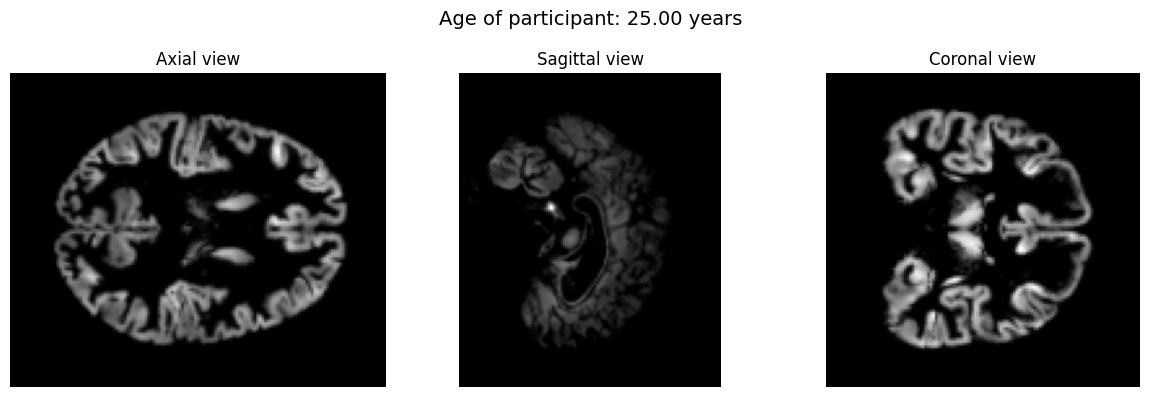

In [ ]:
# Plot MRIs

for x_batch, y_batch in dataset.take(1):
    volume = x_batch[0]
    age = y_batch[0].numpy()

    # Calculate central indixes
    axial_idx = volume.shape[2] // 2      #along z-axis
    sagittal_idx = volume.shape[0] // 2   #along x-axis
    coronal_idx = volume.shape[1] // 2    #along y-axis

    # Extract slice images along the 3 dimensions
    axial_slice = volume[:, :, axial_idx, 0]
    sagittal_slice = volume[sagittal_idx, :, :, 0]
    coronal_slice = volume[:, coronal_idx, :, 0]

    # Plot in subplot
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(axial_slice, cmap='gray')
    axs[0].set_title("Axial view")

    axs[1].imshow(sagittal_slice, cmap='gray')
    axs[1].set_title("Sagittal view")

    axs[2].imshow(coronal_slice, cmap='gray')
    axs[2].set_title("Coronal view")

    fig.suptitle(f"Age of participant: {age:.2f} years", fontsize=14)

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Load and Preprocess Data for ML (non-deep algorithms)

# Load data
df_labels = pd.read_csv(labels_path, sep='\t')

# Target
age = df_labels.age

# Features
tiv = df_labels.tiv                        #total intracranial volume (cm^3)
gmv = df_labels.gmv                        #gray matter volume (cm^3)
wmv = df_labels.wmv                        #white matter volume (cm^3)
csfv = df_labels.csfv                      #cerebrospinal fluid volume (cm^3)
mft = df_labels.magnetic_field_strength    #magnetic field strength (Tesla)



# Target
y = df_labels.age

# Numerical Features ( before and after scaling)
X0 = df_labels[['tiv', 'gmv', 'wmv', 'csfv', 'magnetic_field_strength']]

scaler = StandardScaler()
X0_scaled = scaler.fit_transform(X0)
X0_data = pd.DataFrame(X0_scaled, columns = X0.columns)

# Categorical Features (study, sex, site)
df_encoded = pd.get_dummies(df_labels, columns = ['study', 'sex', 'site'], drop_first = True)
df_cat = [col for col in df_encoded.columns if col.startswith('study_') or
                                            col.startswith('sex_') or
                                             col.startswith('site_')]

X_cat = df_encoded[df_cat]

# Combine all features
X = pd.concat([X0_data, X_cat], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

df_labels

,participant_id,study,sex,age,site,diagnosis,tiv,csfv,gmv,wmv,magnetic_field_strength,acquisition_setting,split
0,100053248969,8,female,19.000000,48.0,control,1434.357361,219.565569,678.230161,535.878459,3.0,1.0,NaN
1,100263562592,4,male,21.000000,3.0,control,1558.161428,261.968669,756.742506,538.817738,3.0,1.0,NaN
2,100479214233,2,female,21.000000,29.0,control,1418.050690,242.123816,686.814910,488.740580,3.0,1.0,NaN
3,100544064116,3,female,15.000000,65.0,control,1304.233543,206.305238,667.809720,429.723510,3.0,1.0,NaN
4,101404752059,4,male,31.000000,3.0,control,1660.856147,344.783456,703.484560,611.222413,3.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3979,996920646374,5,male,34.206708,36.0,control,1382.644103,339.404441,564.440063,477.370447,3.0,3.0,internal_test
3980,997655642426,8,female,21.000000,47.0,control,1343.537471,263.475792,644.483412,434.997137,3.0,1.0,internal_test
3981,998581369878,2,male,21.666667,15.0,control,1550.326703,250.574560,735.601036,563.082731,3.0,1.0,external_test
3982,998587653727,5,male,45.859001,36.0,control,1584.481992,319.352957,654.915781,606.576325,1.5,1.0,external_test


MAE = 4.50
MSE = 39.48
R2 = 0.81 
 

Most relevant features: 
 
   Feature  Coefficients
0     tiv    128.835929
1     gmv    -84.934624
2     wmv    -54.176634
3    csfv    -51.857065


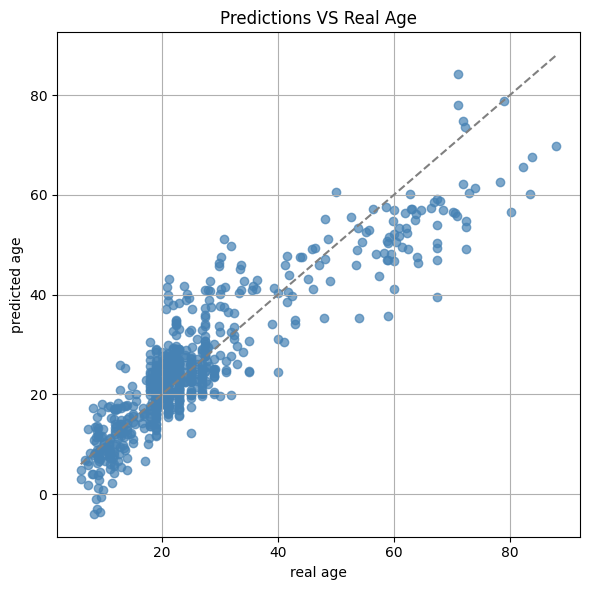

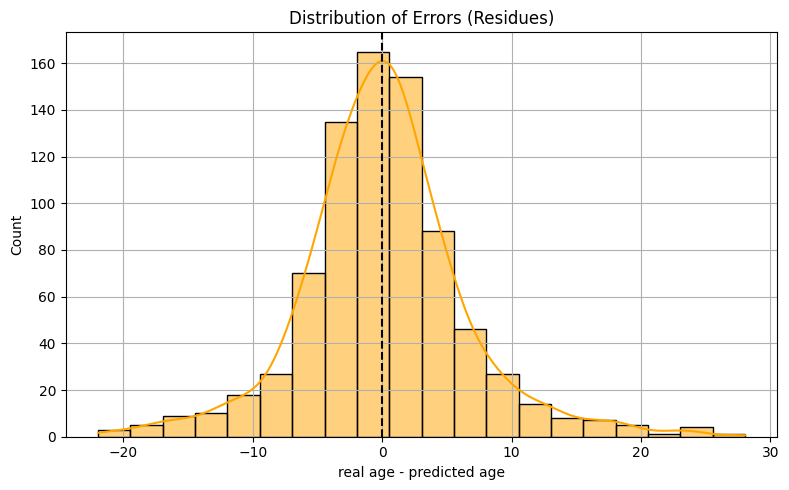

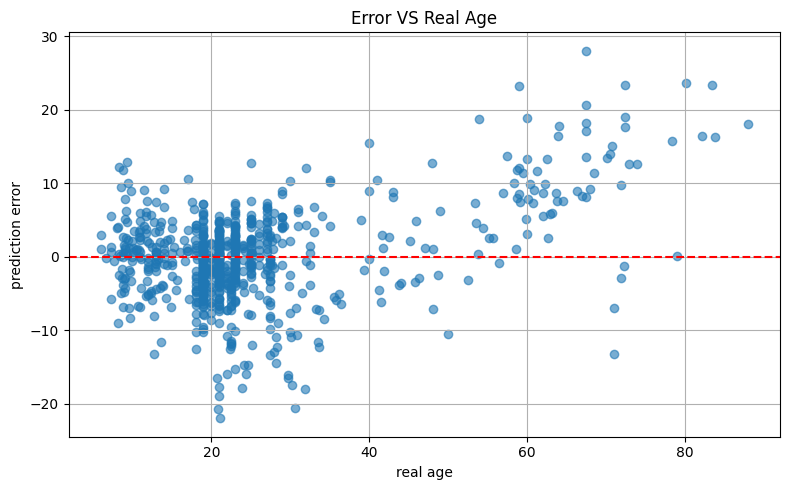

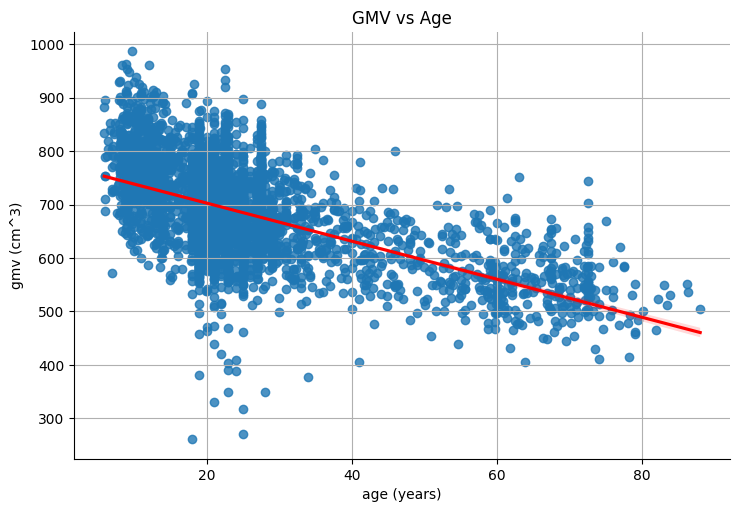

In [ ]:
# Linear Regression

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

# Calculate and print accuracy metrics
MAE_LR = mean_absolute_error(y_test, y_pred)
MSE_LR = mean_squared_error(y_test, y_pred)
R2_LR = r2_score(y_test, y_pred)

print(f"MAE = {MAE_LR:.2f}")
print(f"MSE = {MSE_LR:.2f}")
print(f"R2 = {R2_LR:.2f} \n \n")


# Extract coefficients of various features
features = X.columns
coefs = reg.coef_

coef_pd = pd.DataFrame({
    'Feature': features,
    'Coefficients': coefs
}).sort_values(by='Coefficients', key=abs, ascending=False)

top_features = coef_pd.reindex(coef_pd['Coefficients'].abs().sort_values(ascending=False).index).head(4)

print("Most relevant features: \n \n", top_features)


#
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
plt.xlabel("real age")
plt.ylabel("predicted age")
plt.title("Predictions VS Real Age")
plt.grid(True)
plt.tight_layout()
plt.show()

errors = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=20, kde=True, color='orange')
plt.title("Distribution of Errors (Residues)")
plt.xlabel("real age - predicted age")
plt.axvline(0, color='black', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
plt.scatter(y_test, errors, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("real age")
plt.ylabel("prediction error")
plt.title("Error VS Real Age")
plt.grid(True)
plt.tight_layout()
plt.show()


sns.lmplot(data=df_labels, x='age', y='gmv', height=5, aspect=1.5, line_kws={'color': 'red'})
plt.title('GMV vs Age')
plt.grid(True)
plt.ylabel("gmv (cm^3)")
plt.xlabel("age (years)")
plt.show()


MAE Training Set: 1.22
MAE Test Set: 3.28
MAE Test Set - MAE Train Set: 2.05 

MSE Test Set: 24.48
R2 Test Set: 0.88 
 

                    Feature  Importance
1                       gmv    0.211334
3                      csfv    0.167826
47                site_36.0    0.115062
8                   study_5    0.111515
0                       tiv    0.064260
2                       wmv    0.060686
4   magnetic_field_strength    0.050670
46                site_35.0    0.023446
5                   study_2    0.022957
49                site_38.0    0.020454


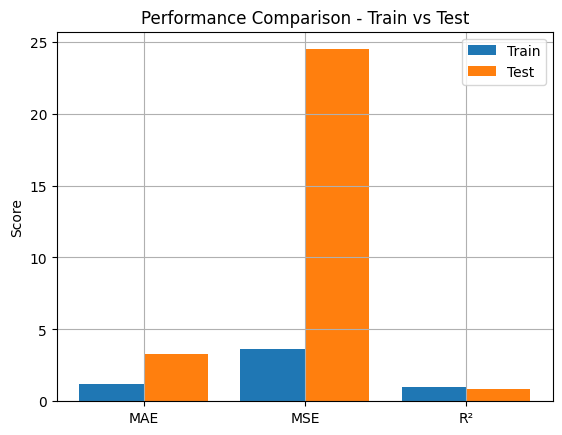

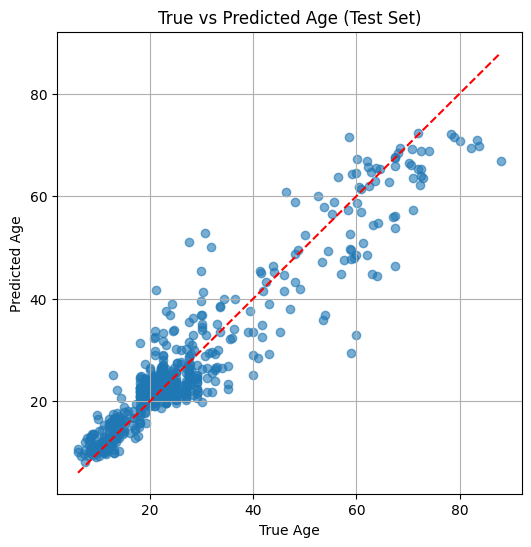

<ipython-input-10-5afd4fa14f55>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


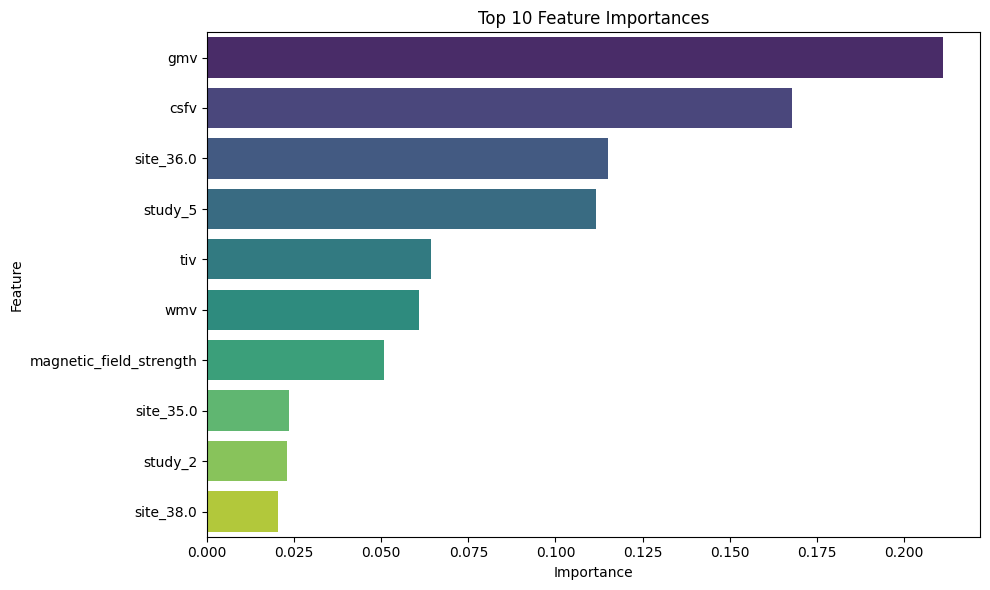

In [ ]:
# Random Forest Benchmark

RanFor = RandomForestRegressor(n_estimators=500, random_state = SEED, max_features = 'sqrt')

RanFor.fit(X_train, y_train)

y_train_pred = RanFor.predict(X_train)
y_test_pred = RanFor.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

R2_train = r2_score(y_train, y_train_pred)
R2_test = r2_score(y_test, y_test_pred)

print(f"MAE Training Set: {MAE_train:.2f}")
print(f"MAE Test Set: {MAE_test:.2f}")
print(f"MAE Test Set - MAE Train Set: {MAE_test - MAE_train:.2f} \n")

print(f"MSE Test Set: {MSE_test:.2f}")
print(f"R2 Test Set: {R2_test:.2f} \n \n")

importances = RanFor.feature_importances_

df_feat = pd.DataFrame({'Feature': features, 'Importance': importances})
df_feat_sorted = df_feat.sort_values(by='Importance', ascending=False)
print(df_feat_sorted.head(10))


metrics = ['MAE', 'MSE', 'R²']
train_scores = [MAE_train, MSE_train, R2_train]
test_scores = [MAE_test, MSE_test, R2_test]

x = range(len(metrics))
plt.bar(x, train_scores, width=0.4, label='Train', align='center')
plt.bar([p + 0.4 for p in x], test_scores, width=0.4, label='Test', align='center')
plt.xticks([p + 0.2 for p in x], metrics)
plt.ylabel("Score")
plt.title("Performance Comparison - Train vs Test")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("True vs Predicted Age (Test Set)")
plt.grid(True)
plt.show()

top_k = 10
top_features = df_feat_sorted.head(top_k)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
# Random Forest Randomized Parameter Search

param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(2, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=SEED),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

random_search_rf.fit(X_train, y_train)


y_train_pred = random_search_rf.predict(X_train)
y_test_pred = random_search_rf.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

R2_train = r2_score(y_train, y_train_pred)
R2_test = r2_score(y_test, y_test_pred)

print(f"MAE Training Set: {MAE_train:.2f}")
print(f"MAE Test Set: {MAE_test:.2f}")
print(f"MAE Test Set - MAE Train Set: {MAE_test - MAE_train:.2f} \n")

print(f"MSE Test Set: {MSE_test:.2f}")
print(f"R2 Test Set: {R2_test:.2f} \n \n")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
MAE Training Set: 2.20
MAE Test Set: 3.41
MAE Test Set - MAE Train Set: 1.21 

MSE Test Set: 25.83
R2 Test Set: 0.88 
 



In [ ]:
# Gradient Boosting Benchmark

GB = GradientBoostingRegressor(n_estimators = 500, learning_rate = 0.01, max_depth = 5, random_state = SEED)

GradBoost = GB.fit(X_train, y_train)

y_train_pred = GradBoost.predict(X_train)
y_test_pred = GradBoost.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

R2_train = r2_score(y_train, y_train_pred)
R2_test = r2_score(y_test, y_test_pred)

print(f"MAE Training Set: {MAE_train:.2f}")
print(f"MAE Test Set: {MAE_test:.2f}")
print(f"MAE Test Set - MAE Train Set: {MAE_test - MAE_train:.2f} \n")

print(f"MSE Test Set: {MSE_test:.2f}")
print(f"R2 Test Set: {R2_test:.2f} \n \n")

MAE Training Set: 2.74
MAE Test Set: 3.32
MAE Test Set - MAE Train Set: 0.58 

MSE Test Set: 24.50
R2 Test Set: 0.88 
 



In [ ]:
#Gradient Boosting Randomized Parameter Search

param_distributions = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.005, 0.1),
    'max_depth': randint(2, 6),
    'subsample': uniform(0.7, 0.3),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

random_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=SEED),
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print(f"MAE Training Set: {MAE_train:.2f}")
print(f"MAE Test Set: {MAE_test:.2f}")
print(f"MAE Test Set - MAE Train Set: {MAE_test - MAE_train:.2f} \n")

print(f"MSE Test Set: {MSE_test:.2f}")
print(f"R2 Test Set: {R2_test:.2f} \n \n")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
MAE Training Set: 2.74
MAE Test Set: 3.32
MAE Test Set - MAE Train Set: 0.58 

MSE Test Set: 24.50
R2 Test Set: 0.88 
 



In [ ]:
#XGBoost Randomized Parameter Search

param_distributions = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.005, 0.1),
    'max_depth': randint(2, 6),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Set up the randomized search
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=SEED,
    tree_method='hist',        # or 'gpu_hist' if using GPU
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best estimator
best_xgb = random_search.best_estimator_
print("Best params:", random_search.best_params_)

# Predictions
y_train_pred = best_xgb.predict(X_train)
y_test_pred  = best_xgb.predict(X_test)

# Metrics
MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test  = mean_absolute_error(y_test, y_test_pred)
MSE_test  = mean_squared_error(y_test, y_test_pred)
R2_test   = r2_score(y_test, y_test_pred)

# Output results
print(f"MAE Training Set: {MAE_train:.2f}")
print(f"MAE Test Set:     {MAE_test:.2f}")
print(f"Overfitting gap (MAE Test - MAE Train): {MAE_test - MAE_train:.2f}\n")

print(f"MSE Test Set: {MSE_test:.2f}")
print(f"R² Test Set:  {R2_test:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'colsample_bytree': np.float64(0.8835162238703056), 'gamma': np.float64(2.0980003121389497), 'learning_rate': np.float64(0.029773098950115748), 'max_depth': 5, 'n_estimators': 534, 'reg_alpha': np.float64(0.7578461104643691), 'reg_lambda': np.float64(0.014393488629755868), 'subsample': np.float64(0.7348217921520748)}
MAE Training Set: 2.15
MAE Test Set:     3.14
Overfitting gap (MAE Test - MAE Train): 0.99

MSE Test Set: 21.66
R² Test Set:  0.90


In [ ]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

In [ ]:
# Train-Test Splitting for CNN

total_len = len(X_paths)
split_index = int(0.8 * total_len)

# Shuffle indices
indices = tf.random.shuffle(tf.range(total_len), seed=SEED)

train_indices = indices[:split_index]
test_indices = indices[split_index:]

# Create data subsets
X_paths_tensor_train = tf.gather(X_paths_tensor, train_indices)
y_tensor_train = tf.gather(y_tensor, train_indices)

X_paths_tensor_test = tf.gather(X_paths_tensor, test_indices)
y_tensor_test = tf.gather(y_tensor, test_indices)

# Crea two subsets
tf_data_train = tf.data.Dataset.from_tensor_slices((X_paths_tensor_train, y_tensor_train))
tf_data_test = tf.data.Dataset.from_tensor_slices((X_paths_tensor_test, y_tensor_test))

# Preprocess and batch
dataset_train = tf_data_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset_train = dataset_train.batch(1).prefetch(tf.data.AUTOTUNE)

dataset_test = tf_data_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dataset_test = dataset_test.batch(1).prefetch(tf.data.AUTOTUNE)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 121, 145, 121,  │           224 │
│                                 │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 121, 145, 121,  │         3,472 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 60, 72, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 60, 72, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 30, 36, 30, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 30, 36, 30, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,137 (301.32 KB)

 Trainable params: 77,137 (301.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3187/3187 - 308s - 97ms/step - loss: 245.7603 - mae: 10.5334 - val_loss: 227.2210 - val_mae: 8.6758
Epoch 2/10
3187/3187 - 298s - 93ms/step - loss: 232.3877 - mae: 10.2371 - val_loss: 218.8038 - val_mae: 8.4899
Epoch 3/10
3187/3187 - 296s - 93ms/step - loss: 222.8754 - mae: 9.9409 - val_loss: 212.7265 - val_mae: 8.5534
Epoch 4/10
3187/3187 - 297s - 93ms/step - loss: 219.6778 - mae: 9.9277 - val_loss: 208.1566 - val_mae: 8.4859
Epoch 5/10
3187/3187 - 295s - 93ms/step - loss: 209.5174 - mae: 9.7578 - val_loss: 202.7331 - val_mae: 8.2257
Epoch 6/10
3187/3187 - 294s - 92ms/step - loss: 180.3269 - mae: 9.1476 - val_loss: 125.1106 - val_mae: 7.0624
Epoch 7/10
3187/3187 - 291s - 91ms/step - loss: 149.6636 - mae: 8.3264 - val_loss: 100.8286 - val_mae: 6.6988
Epoch 8/10
3187/3187 - 292s - 91ms/step - loss: 147.9137 - mae: 8.2215 - val_loss: 95.9496 - val_mae: 6.6774
Epoch 9/10
3187/3187 - 293s - 92ms/step - loss: 144.1008 - mae: 8.0600 - val_loss: 97.1460 - val_mae: 6.7869
Epoch 10/1

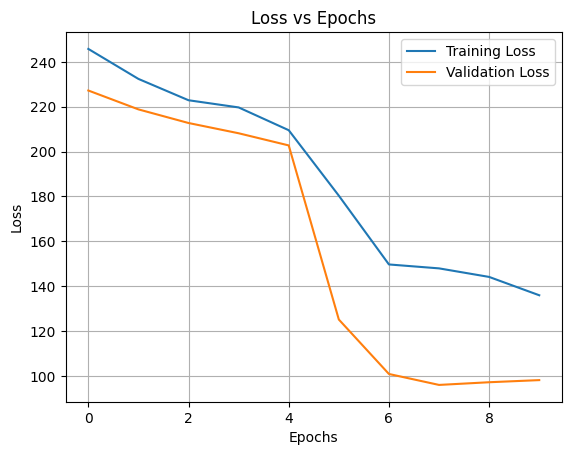

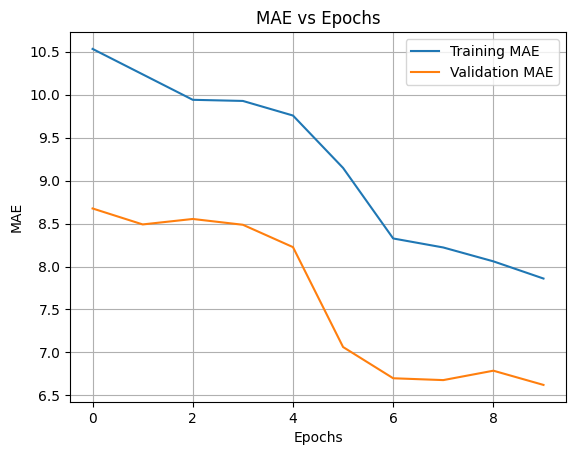

3187/3187 ━━━━━━━━━━━━━━━━━━━━ 233s 73ms/step - loss: 115.9081 - mae: 6.7061
797/797 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - loss: 86.1237 - mae: 6.1085

Train → Loss: 104.03 - MAE: 6.57
Test  → Loss: 98.09 - MAE: 6.62
Training time: 49.27 minutes
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/s

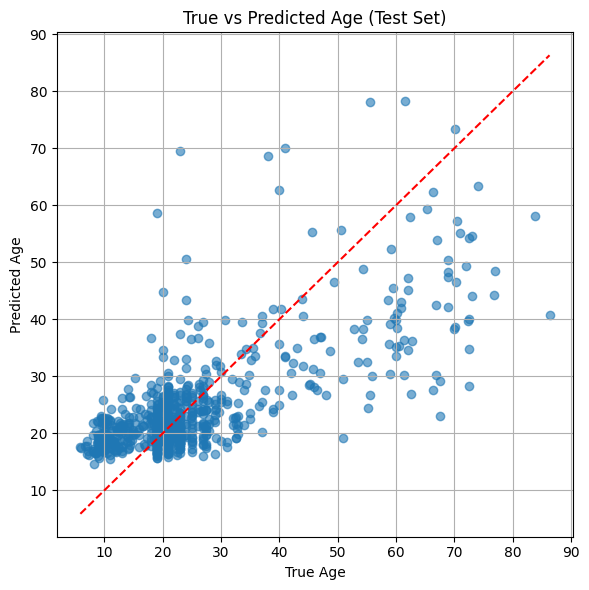

In [ ]:
# Benchmark CNN

# Compact CNN architecture
model = models.Sequential([
    layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same', input_shape=(121, 145, 121, 1)),
    layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same'),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),

    layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
    layers.GlobalAveragePooling3D(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')
])

model.summary()

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)

# Training
start_time = time.time()

history = model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_test,
    verbose=2
)

end_time = time.time()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('MAE vs Epochs')
plt.legend()
plt.grid()
plt.show()

# Save the model
model.save("compact_benchmark_model.h5")

# Final evaluation
train_loss, train_mae = model.evaluate(dataset_train, verbose=1)
test_loss, test_mae = model.evaluate(dataset_test, verbose=1)

print(f"\nTrain → Loss: {train_loss:.2f} - MAE: {train_mae:.2f}")
print(f"Test  → Loss: {test_loss:.2f} - MAE: {test_mae:.2f}")
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

# True vs Predicted plot (Test set)
y_true = []
y_pred = []

for x_batch, y_batch in dataset_test:
    preds = model.predict(x_batch)
    y_true.extend(y_batch.numpy())
    y_pred.extend(preds.flatten())

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("True vs Predicted Age (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
input_shape = (121, 145, 121, 1)

# ---- Residual block helper ----
def res_block(x, filters, kernel_size=(3,3,3), pool=False):
    """
    Block: Conv3D -> BN -> ReLU -> Conv3D -> BN + skip -> ReLU -> (optional MaxPool)
    """
    shortcut = x
    x = layers.Conv3D(filters, kernel_size, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters, kernel_size, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # 1×1×1 conv on shortcut if channel dims don’t match
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv3D(filters, (1,1,1), padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    if pool:
        x = layers.MaxPooling3D((2,2,2))(x)
    return x

# ---- Model definition ----
inp = Input(shape=input_shape)

# Stem
x = layers.Conv3D(16, (3,3,3), padding='same', use_bias=False)(inp)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Residual blocks
x = res_block(x, 32, pool=True)   # downsample
x = res_block(x, 64, pool=True)   # downsample
x = res_block(x, 128, pool=True)  # downsample

# Transition
x = layers.GlobalAveragePooling3D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Output
out = layers.Dense(1, activation='linear')(x)

model = Model(inputs=inp, outputs=out, name='Res3D_CNN')

# ---- Compile ----
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

# ---- Summary ----
model.summary()

# Train the model
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10,
    verbose=2
)

# Evaluate on test set
loss, mae = model.evaluate(ds_test, verbose=1)
print(f"Test MAE: {mae:.2f}")

# Import plotting library
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Training & Validation MAE
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Model: "Res3D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 121, 145,  │          0 │ -                 │
│ (InputLayer)        │ 121, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 121, 145,  │        432 │ input_layer_2[0]… │
│                     │ 121, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 121, 145,  │         64 │ conv3d_6[0][0]    │
│ (BatchNormalizatio… │ 121, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 121, 145,  │          0 │ batch_normalizat… │
│ (Activation)        │ 121, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 121, 145,  │     13,824 │ activation[0][0]  │
│                     │ 121, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 121, 145,  │        128 │ conv3d_7[0][0]    │
│ (BatchNormalizatio… │ 121, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 121, 145,  │          0 │ batch_normalizat… │
│ (Activation)        │ 121, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 121, 145,  │     27,648 │ activation_1[0][… │
│                     │ 121, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 121, 145,  │        512 │ activation[0][0]  │
│                     │ 121, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 121, 145,  │        128 │ conv3d_8[0][0]    │
│ (BatchNormalizatio… │ 121, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 121, 145,  │        128 │ conv3d_9[0][0]    │
│ (BatchNormalizatio… │ 121, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 121, 145,  │          0 │ batch_normalizat… │
│                     │ 121, 32)          │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 121, 145,  │          0 │ add[0][0]         │
│ (Activation)        │ 121, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 60, 72,    │          0 │ activation_2[0][… │
│ (MaxPooling3D)      │ 60, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_10 (Conv3D)  │ (None, 60, 72,    │     55,296 │ max_pooling3d_4[… │
│                     │ 60, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 72,    │        256 │ conv3d_10[0][0]   │
│ (BatchNormalizatio… │ 60, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 60, 72,    │          0 │ batch_normalizat

 Total params: 934,385 (3.56 MB)

 Trainable params: 933,009 (3.56 MB)

 Non-trainable params: 1,376 (5.38 KB)

NameError: name 'ds_train' is not defined

In [ ]:
# --- Preprocessing Cell for Fusion Model ---


# Paths
sMRI_path    = '/content/complete_vbm/'
labels_path  = '/content/drive/MyDrive/OpenBHB/dataset_complete/labels_tsv/participants_all.tsv'

# 1. Load labels and build tabular features
df_labels = pd.read_csv(labels_path, sep='\t')

# Numeric features + scaling
num_cols = ['tiv', 'gmv', 'wmv', 'csfv', 'magnetic_field_strength']
scaler   = StandardScaler()
df_num   = pd.DataFrame(
    scaler.fit_transform(df_labels[num_cols]),
    columns=num_cols,
    index=df_labels.index
)

# Categorical one-hot encoding
df_cat = pd.get_dummies(df_labels[['study','sex','site']], drop_first=True)

# Combine into single DataFrame
df_tab = pd.concat([df_num, df_cat], axis=1)

# 2. Align MRI file paths, labels, and tabular features
X_paths, y, tab_feats = [], [], []

for fname in os.listdir(sMRI_path):
    path = os.path.join(sMRI_path, fname)
    try:
        np.load(path)  # check load
        pid = int(fname.split('_')[0].split('-')[1])
    except:
        continue
    row = df_labels[df_labels['participant_id'] == pid]
    if len(row) == 1:
        X_paths.append(path)
        y.append(float(row.iloc[0]['age']))
        tab_feats.append(df_tab.loc[row.index[0]].values.astype(np.float32))

# 3. Build tf.data.Dataset
paths_tf = tf.constant(X_paths)
tabs_tf  = tf.constant(np.stack(tab_feats, axis=0))
ages_tf  = tf.constant(y, dtype=tf.float32)

ds = tf.data.Dataset.from_tensor_slices((paths_tf, tabs_tf, ages_tf))

def load_and_preprocess(path, tab, label):
    def _load_npy(p):
        x = np.load(p.decode('utf-8'))
        x = np.squeeze(x) / np.max(x)
        return x.astype(np.float32)[..., np.newaxis]
    img = tf.numpy_function(_load_npy, [path], tf.float32)
    img.set_shape([121, 145, 121, 1])
    return {'mri_input': img, 'tab_input': tab}, label

ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.shuffle(buffer_size=len(X_paths))

# 4. Split into train/test
dataset_size = len(X_paths)
train_size   = int(0.8 * dataset_size)

ds_train = ds.take(train_size)
ds_test  = ds.skip(train_size)

# 5. Batch & prefetch
batch_size = 8
ds_train = ds_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 6. Verify sizes
print(f"Total samples: {dataset_size}")
print(f"Training batches: {tf.data.experimental.cardinality(ds_train).numpy()}")
print(f"Test batches:     {tf.data.experimental.cardinality(ds_test).numpy()}")

In [ ]:
# Fusion Model Definition Cell

# Input shapes
img_shape     = (121, 145, 121, 1)
num_tabular   = df_tab.shape[1]      # from preprocessing cell

# MRI branch
mri_input = Input(shape=img_shape, name='mri_input')
x = layers.Conv3D(16, 3, padding='same', activation='relu')(mri_input)
x = layers.MaxPooling3D(2)(x)
x = layers.Conv3D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling3D(2)(x)
x = layers.Conv3D(64, 3, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling3D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
mri_feat = layers.Dense(64, activation='relu', name='mri_feat')(x)

# Tabular branch
tab_input = Input(shape=(num_tabular,), name='tab_input')
y_ = layers.Dense(64, activation='relu')(tab_input)
y_ = layers.BatchNormalization()(y_)
y_ = layers.Dropout(0.3)(y_)
y_ = layers.Dense(32, activation='relu')(y_)
tab_feat = layers.Dense(16, activation='relu', name='tab_feat')(y_)

# Fusion and final regression head
combined = layers.Concatenate(name='fusion')([mri_feat, tab_feat])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dropout(0.3)(z)
z = layers.Dense(32, activation='relu')(z)
output = layers.Dense(1, activation='linear', name='age_output')(z)

# Build & compile model
fusion_model = Model(inputs=[mri_input, tab_input], outputs=output, name='MRI_Tab_Fusion')
fusion_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

# Summary
fusion_model.summary()

# Train the fusion model
history = fusion_model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10,
    verbose=2
)

# Evaluate on test set
test_loss, test_mae = fusion_model.evaluate(ds_test, verbose=1)
print(f"Test Loss: {test_loss:.2f} - Test MAE: {test_mae:.2f}")

# Plot Training & Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Fusion Model: Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Training & Validation MAE
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Fusion Model: MAE vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
